# **Model Selection to estimate Agents**

For each station, find a good model to predict the individual pollutants.

## **Input Data**

Using the process defined in the [training data notebook](./4-training-and-test-sets.ipynb), initiate the datasets.

In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Metrics
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import train_test_split

from utils import *

datasets_folder = './datasets'
figsize = (20,4)
verbosity = 0

metrics = [root_mean_squared_error, r2_score, mean_absolute_error, huber]

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

2025-05-04 12:05:57.431824: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-04 12:05:57.527874: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-04 12:05:57.617641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746385557.698394  121391 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746385557.721207  121391 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746385557.889480  121391 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

[]


2025-05-04 12:06:00.067724: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = pollution_data.keys()

In [3]:
station_data = {}
station_dists = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station], station_dists[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 33


In [4]:
display(station_dists)

{'GIARDINI MARGHERITA': {'NO2': {'mean': np.float64(17.14072246079708),
   'std': np.float64(12.589960677710152)},
  'O3': {'mean': np.float64(48.98458980258706),
   'std': np.float64(37.8528029908811)},
  'PM10': {'mean': np.float64(22.20440402106271),
   'std': np.float64(14.35686586458016)},
  'PM2.5': {'mean': np.float64(14.05708848715509),
   'std': np.float64(11.627470578424944)}},
 'PORTA SAN FELICE': {'C6H6': {'mean': np.float64(0.9688255136461208),
   'std': np.float64(0.7330861483138481)},
  'CO': {'mean': np.float64(0.5785855034386833),
   'std': np.float64(0.31030981035220684)},
  'NO2': {'mean': np.float64(39.715893435784),
   'std': np.float64(19.291885584866137)},
  'PM10': {'mean': np.float64(25.287928604978863),
   'std': np.float64(15.314443827291322)},
  'PM2.5': {'mean': np.float64(15.613508442776736),
   'std': np.float64(11.841427071912088)}},
 'VIA CHIARINI': {'NO2': {'mean': np.float64(17.894255722973234),
   'std': np.float64(13.343056587921156)},
  'O3': {'mea

We can inspect the hourly and daily features:

In [5]:
station_data['GIARDINI MARGHERITA']['NO2'].columns

Index(['Agent_value', 'Traffic_value', 'TAVG', 'PREC', 'RHAVG', 'RAD',
       'W_SCAL_INT', 'W_VEC_DIR', 'LEAFW', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'month_rbf_1', 'month_rbf_2', 'month_rbf_3', 'month_rbf_4',
       'month_rbf_5', 'month_rbf_6', 'month_rbf_7', 'month_rbf_8',
       'month_rbf_9', 'month_rbf_10', 'month_rbf_11', 'month_rbf_12'],
      dtype='object')

In [6]:
station_data['GIARDINI MARGHERITA']['PM2.5'].columns

Index(['Agent_value', 'Traffic_0-2', 'Traffic_3-5', 'Traffic_6-8',
       'Traffic_9-11', 'Traffic_12-14', 'Traffic_15-17', 'Traffic_18-20',
       'Traffic_21-0', 'TAVG', 'PREC', 'RHAVG', 'RAD', 'W_SCAL_INT',
       'W_VEC_DIR', 'LEAFW', 'TAVG_MAX', 'TAVG_MIN', 'RHAVG_MAX', 'RHAVG_MIN',
       'day_sin', 'day_cos', 'month_rbf_1', 'month_rbf_2', 'month_rbf_3',
       'month_rbf_4', 'month_rbf_5', 'month_rbf_6', 'month_rbf_7',
       'month_rbf_8', 'month_rbf_9', 'month_rbf_10', 'month_rbf_11',
       'month_rbf_12'],
      dtype='object')

As we can see for daily data we have the correct encoding of the hourly values for the traffic and the weather (like 'TAVG_MAX','TAVG_MIN', 'RHAVG_MAX', 'RHAVG_MIN') and the data encoding.

## **Training Data**

Our data covers 2019, ..., 2024. We decided to use 2024 as the test set.

In [7]:
train_split_date = datetime(2023,12,31,23)
RANDOM_STATE = 42

In [8]:
train_sets = {}
test_sets = {}

for station in stations:
    train_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        train_sets[station][agent] = {}
        test_sets[station][agent] = {}

        X_train, y_train, X_test, y_test = create_train_test(station_data[station][agent], train_split_date, y='Agent_value')

        train_sets[station][agent]['x'] = X_train
        train_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = X_test
        test_sets[station][agent]['y'] = y_test

In [9]:
train_sets['GIARDINI MARGHERITA']['NO2']['x'].head(1) # example

,Traffic_value,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,-0.548779,-1.741683,-0.13755,1.320229,-0.663642,-1.41615,0.046922,-0.464033,0.0,1.0,...,0.000335,1.522998e-08,1.266417e-14,1.928750e-22,5.380186e-32,1.928750e-22,1.266417e-14,1.522998e-08,0.000335,0.135335


In [10]:
train_sets['GIARDINI MARGHERITA']['NO2']['y'].head(1)

,Agent_value
Date,
2019-01-01,0.941972


In [11]:
train_sets['GIARDINI MARGHERITA']['NO2']['y']

,Agent_value
Date,
2019-01-01 00:00:00,0.941972
2019-01-01 02:00:00,0.465397
2019-01-01 03:00:00,0.941972
2019-01-01 04:00:00,0.703685
2019-01-01 05:00:00,0.544826
...,...
2023-12-31 19:00:00,0.147681
2023-12-31 20:00:00,-0.646611
2023-12-31 21:00:00,-0.884898


In [13]:
def merge_train_sets(train_sets):
    merged_train = {}
    for station in train_sets.keys():
        for agent in train_sets[station].keys():
            if agent not in merged_train:
                merged_train[agent] = {}
                merged_train[agent]['x'] = pd.DataFrame()
                merged_train[agent]['y'] = pd.DataFrame()
            merged_train[agent]['x'] = pd.concat([merged_train[agent]['x'], train_sets[station][agent]['x']], axis=0)
            merged_train[agent]['y'] = pd.concat([merged_train[agent]['y'], train_sets[station][agent]['y']], axis=0)
    return merged_train
merged_train_sets = merge_train_sets(train_sets)
for agent in merged_train_sets.keys():
    print(f'Agent {agent} train set shape: \t{merged_train_sets[agent]["x"].shape}, {merged_train_sets[agent]["y"].shape}')

Agent NO2 train set shape: 	(128614, 24), (128614, 1)
Agent O3 train set shape: 	(85826, 24), (85826, 1)
Agent PM10 train set shape: 	(5283, 33), (5283, 1)
Agent PM2.5 train set shape: 	(3519, 33), (3519, 1)
Agent C6H6 train set shape: 	(40778, 24), (40778, 1)
Agent CO train set shape: 	(43036, 24), (43036, 1)


## **Models**

We define different model architectures to try evaluate the pollutants.

A good result would be a certain architecture resulting in the best results for certain agents across all the stations, or even across all the agents.

Certain models will use sequences as input, for example LSTMs and Convolutional Networks.

The clear problem of this approach is the fact that it is really hard to find, while testing, a model able to work well with all the agents after being tested on a small subset of them. We will be able to check if the model actually work nice on other agents, but it will most likely work very well just with the agents it has been tested on.

The following models have been tested and produced good results. We will now test all of them across all the stations and agents.

### **Hourly Models**

In [144]:
hour_models = {} # contains tuples: (ModelGenerator, model_params:dict, training_params:dict|None, uses_sequences:bool)

#### Random Forest Regressor

##### *Models*

In [145]:
rfr_params = {
    'n_estimators':300,
    'max_depth':20,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

hour_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

In [146]:
rfr2_params = {
    'n_estimators':500,
    'max_depth':15,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

hour_models['Random Forest Regressor 2'] = (RandomForestRegressor, rfr2_params, None, False)

##### *Testing*

In [118]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_rfr = 'Random Forest Regressor'

In [119]:
rfr_model = RandomForestRegressor(**hour_models[selected_rfr][1])
rfr_model.fit(merged_train_sets[agent]['x'], merged_train_sets[agent]['y'].to_numpy().ravel())
rfr_pred = rfr_model.predict(test_sets[station][agent]['x'])
rfr_pred_df = pd.DataFrame(rfr_pred, index=test_sets[station][agent]['y'].index)

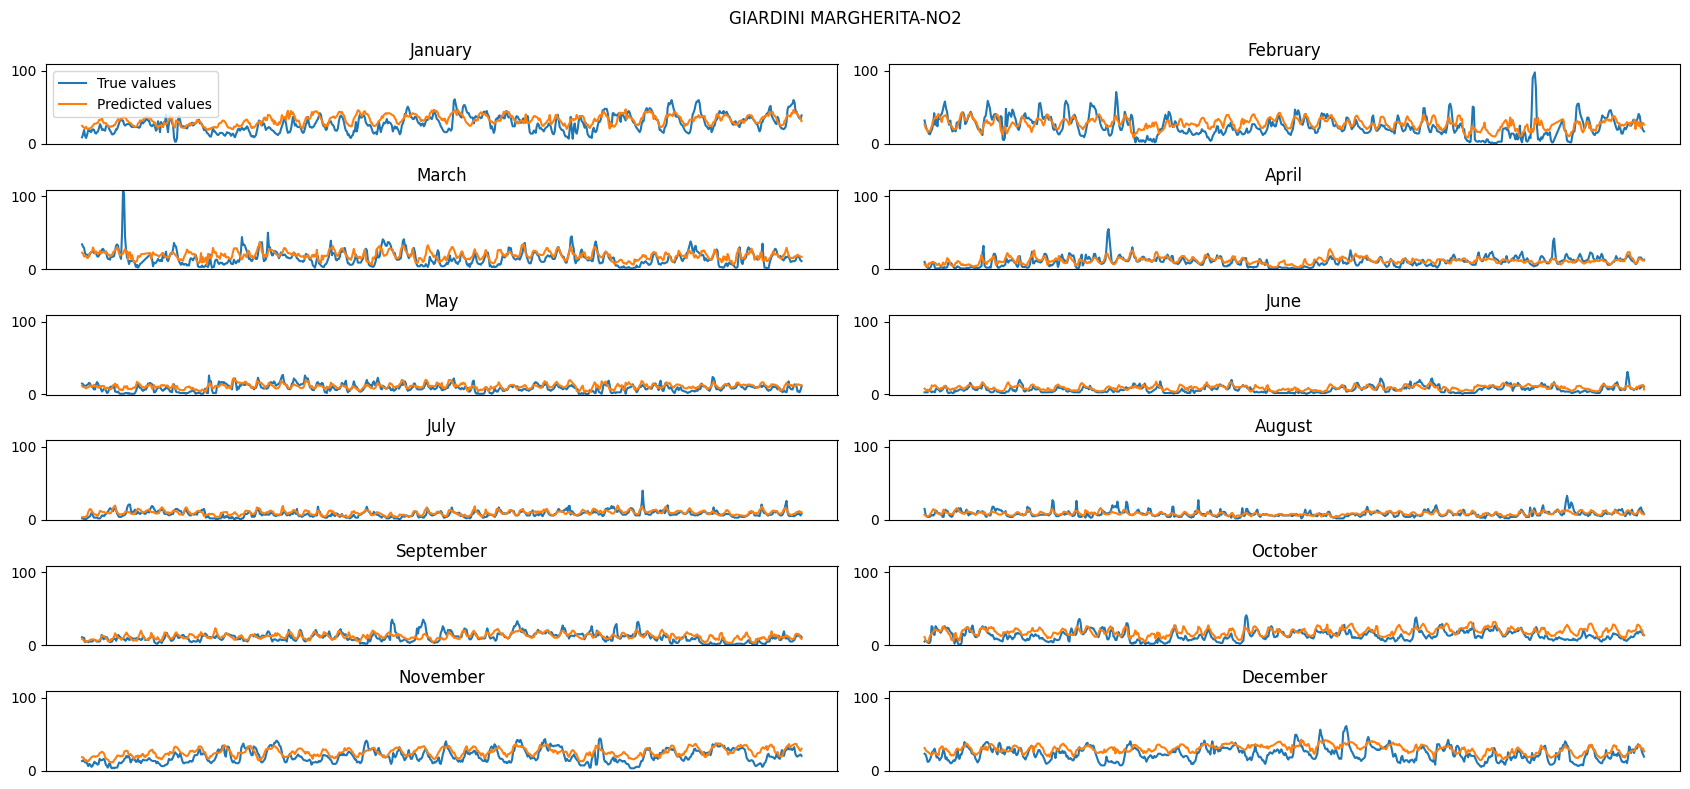

root_mean_squared_error: 0.594279828627462
r2_score: 0.4989776253800302
mean_absolute_error: 0.44073369519726263
huber: 0.07025707513093948
mean_squared_error: 0.3531685147134856


In [120]:
plot_months_predictions(test_sets[station][agent]['y'], rfr_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

#### XGBoost

##### *Models*

In [147]:
xgbr_params = {
    'objective': "reg:absoluteerror",
    'n_estimators': 180,
    'max_depth': 6,
    'learning_rate': 0.07,
    'subsample': 0.9,
    'random_state': RANDOM_STATE
}

hour_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

In [148]:
xgbr2_params = {
    'objective': "reg:squarederror",
    'n_estimators': 250,
    'max_depth': 10,
    'learning_rate': 0.1,
    'subsample': 0.75,
    'random_state': RANDOM_STATE
}

hour_models['XGB Regressor 2'] = (xgb.XGBRegressor, xgbr2_params, None, False)

##### *Testing*

In [132]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_xgbr = 'XGB Regressor'

In [133]:
validation_ratio = 0.1

X_train, y_train = merged_train_sets[agent]['x'], merged_train_sets[agent]['y']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42, shuffle=True)
validation_data = [(X_val, y_val)]

xgbr_model = xgb.XGBRegressor(**hour_models[selected_xgbr][1])
xgbr_model.fit(X_train, y_train, eval_set=validation_data)
xgbr_pred = xgbr_model.predict(test_sets[station][agent]['x'])
xgbr_pred_df = pd.DataFrame(xgbr_pred, index=test_sets[station][agent]['y'].index)

[0]	validation_0-mae:0.77954
[1]	validation_0-mae:0.75116
[2]	validation_0-mae:0.72533
[3]	validation_0-mae:0.70201
[4]	validation_0-mae:0.68127
[5]	validation_0-mae:0.66203
[6]	validation_0-mae:0.64488
[7]	validation_0-mae:0.62911
[8]	validation_0-mae:0.61531
[9]	validation_0-mae:0.60191
[10]	validation_0-mae:0.59008
[11]	validation_0-mae:0.57931
[12]	validation_0-mae:0.56978
[13]	validation_0-mae:0.56106
[14]	validation_0-mae:0.55300
[15]	validation_0-mae:0.54548
[16]	validation_0-mae:0.53837
[17]	validation_0-mae:0.53195
[18]	validation_0-mae:0.52619
[19]	validation_0-mae:0.52097
[20]	validation_0-mae:0.51657
[21]	validation_0-mae:0.51192
[22]	validation_0-mae:0.50771
[23]	validation_0-mae:0.50376
[24]	validation_0-mae:0.50037
[25]	validation_0-mae:0.49730
[26]	validation_0-mae:0.49397
[27]	validation_0-mae:0.49122
[28]	validation_0-mae:0.48858
[29]	validation_0-mae:0.48612
[30]	validation_0-mae:0.48417
[31]	validation_0-mae:0.48216
[32]	validation_0-mae:0.48030
[33]	validation_0-ma

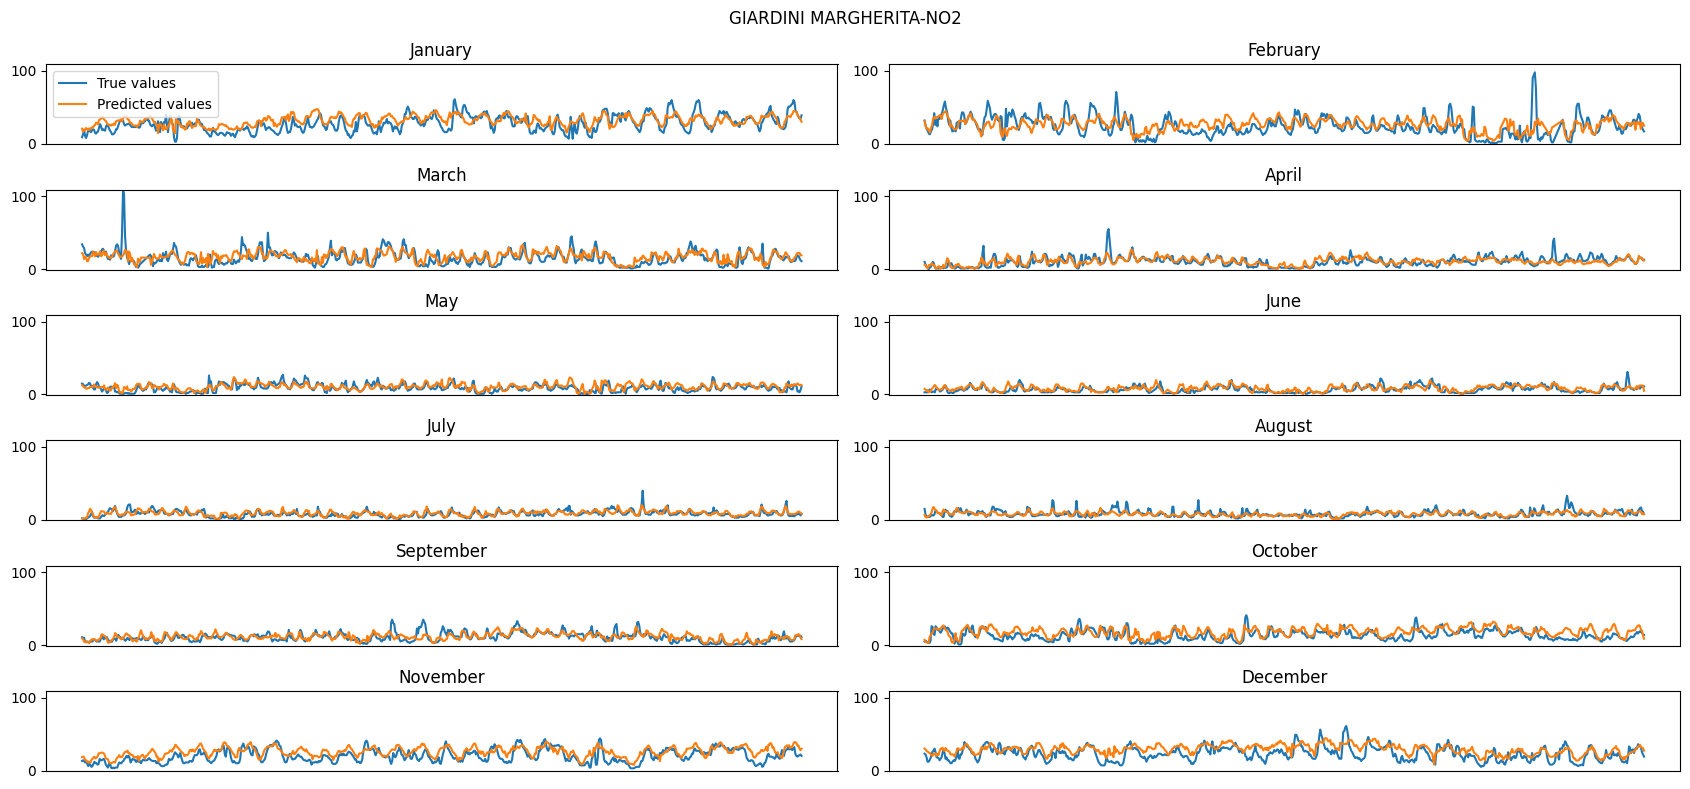

root_mean_squared_error: 0.5794168796341527
r2_score: 0.523725392240904
mean_absolute_error: 0.418073967773765
huber: 0.06620456278324127
mean_squared_error: 0.3357239204049781


In [134]:
plot_months_predictions(test_sets[station][agent]['y'], xgbr_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

#### LSTM

##### *Models*

In [103]:
lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'lstm_units': 128,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error',
    'use_mask': False # fill nan using bfill()
}

lstm_train_params = {
    'epochs':1,
    'batch_size':64,
}

hour_models['LSTM'] = (build_lstm_model, lstm_params, lstm_train_params, True)

In [26]:
masked_lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'lstm_units': 128,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error',
    'use_mask': True # apply a mask to nan, instead of filling
}

masked_lstm_train_params = {
    'epochs':50,
    'batch_size':32,
}

hour_models['LSTM-masked'] = (build_lstm_model, masked_lstm_params, masked_lstm_train_params, True)

In [27]:
lstm2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'lstm_units': [64, 32],
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error',
    'use_mask': False
}

lstm2_train_params = {
    'epochs':20,
    'batch_size':32,
}

hour_models['LSTM 2'] = (build_lstm_model, lstm2_params, lstm2_train_params, True)


In [28]:
masked_lstm2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'lstm_units': [64, 32],
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error',
    'use_mask': True
}

masked_lstm2_train_params = {
    'epochs':20,
    'batch_size':32,
}

hour_models['LSTM 2-masked'] = (build_lstm_model, masked_lstm2_params, masked_lstm2_train_params, True)


##### *Testing*

In [29]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_lstm = 'LSTM-masked'

In [30]:
validation_ratio = 0.1
selected_lstm_model = hour_models[selected_lstm]

ts = selected_lstm_model[1]['time_steps']
# lstm_X_train, lstm_y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)

lstm_X_train, lstm_y_train = None, None
for station in stations:
    if agent in train_sets[station].keys():
        X_train, y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)
        if lstm_X_train is None:
            lstm_X_train = X_train
            lstm_y_train = y_train
        else:
            lstm_X_train = np.concatenate((lstm_X_train, X_train), axis=0)
            lstm_y_train = np.concatenate((lstm_y_train, y_train), axis=0)

lstm_X_test = pd.concat([train_sets[station][agent]['x'].iloc[-ts+1:], test_sets[station][agent]['x']]) # to also compute the first days we need time_steps more days
lstm_X_test, lstm_y_test = create_sequences(lstm_X_test, test_sets[station][agent]['y'], ts, use_mask=False)

lstm_X_train, lstm_X_val, lstm_y_train, lstm_y_val = train_test_split(lstm_X_train, lstm_y_train, test_size=validation_ratio, random_state=42, shuffle=True)

In [31]:
lstm_X_train, lstm_X_val, lstm_y_train, lstm_y_val = train_test_split(lstm_X_train, lstm_y_train, test_size=validation_ratio, random_state=42, shuffle=True)

In [32]:
selected_lstm_model

(<function utils.models.build_lstm_model(time_steps: int, n_features: int, lstm_units: int | list[int], mask_value=-999.0, activation='relu', optimizer='adam', loss='mean_absolute_error', **kwargs)>,
 {'time_steps': 3,
  'n_features': 24,
  'lstm_units': 128,
  'optimizer': <keras.src.optimizers.adam.Adam at 0x7358db59eae0>,
  'loss': 'mean_absolute_error',
  'use_mask': True},
 {'epochs': 50, 'batch_size': 32},
 True)

Epoch 1/50


/home/davide/Desktop/AI/AIII/project/AII-project/aiii-venv/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3256/3256 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.5145 - val_loss: 0.4810
Epoch 2/50
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.4744 - val_loss: 0.4731
Epoch 3/50
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.4673 - val_loss: 0.4689
Epoch 4/50
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.4623 - val_loss: 0.4644
Epoch 5/50
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.4582 - val_loss: 0.4617
Epoch 6/50
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.4548 - val_loss: 0.4598
Epoch 7/50
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.4517 - val_loss: 0.4579
Epoch 8/50
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.4486 - val_loss: 0.4557
Epoch 9/50
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.4458 - val_loss: 0.4544
Epoch 10/50
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.4430 - val_loss: 0.4531
Epoch 11/50
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.4406 - val_loss: 0.4507
Epoch 12/50
3256/3256 ━━━━━━━━

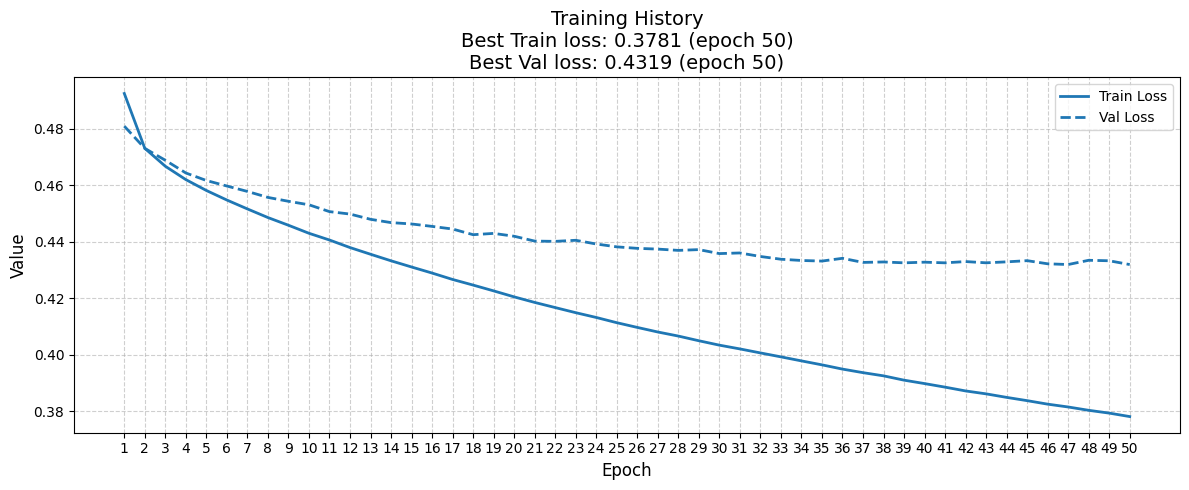

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [33]:
selected_lstm_model = hour_models[selected_lstm]
tf.keras.backend.clear_session()  # Reset TensorFlow state
set_random_seed(42) 
lstm_model = selected_lstm_model[0](**selected_lstm_model[1])
lstm_history = lstm_model.fit(
    lstm_X_train,
    lstm_y_train,
    validation_data=(lstm_X_val, lstm_y_val),
    **selected_lstm_model[2],
)
plot_history(lstm_history)
lstm_pred = lstm_model.predict(lstm_X_test)
lstm_pred_df = pd.DataFrame(lstm_pred, index=lstm_y_test.index)

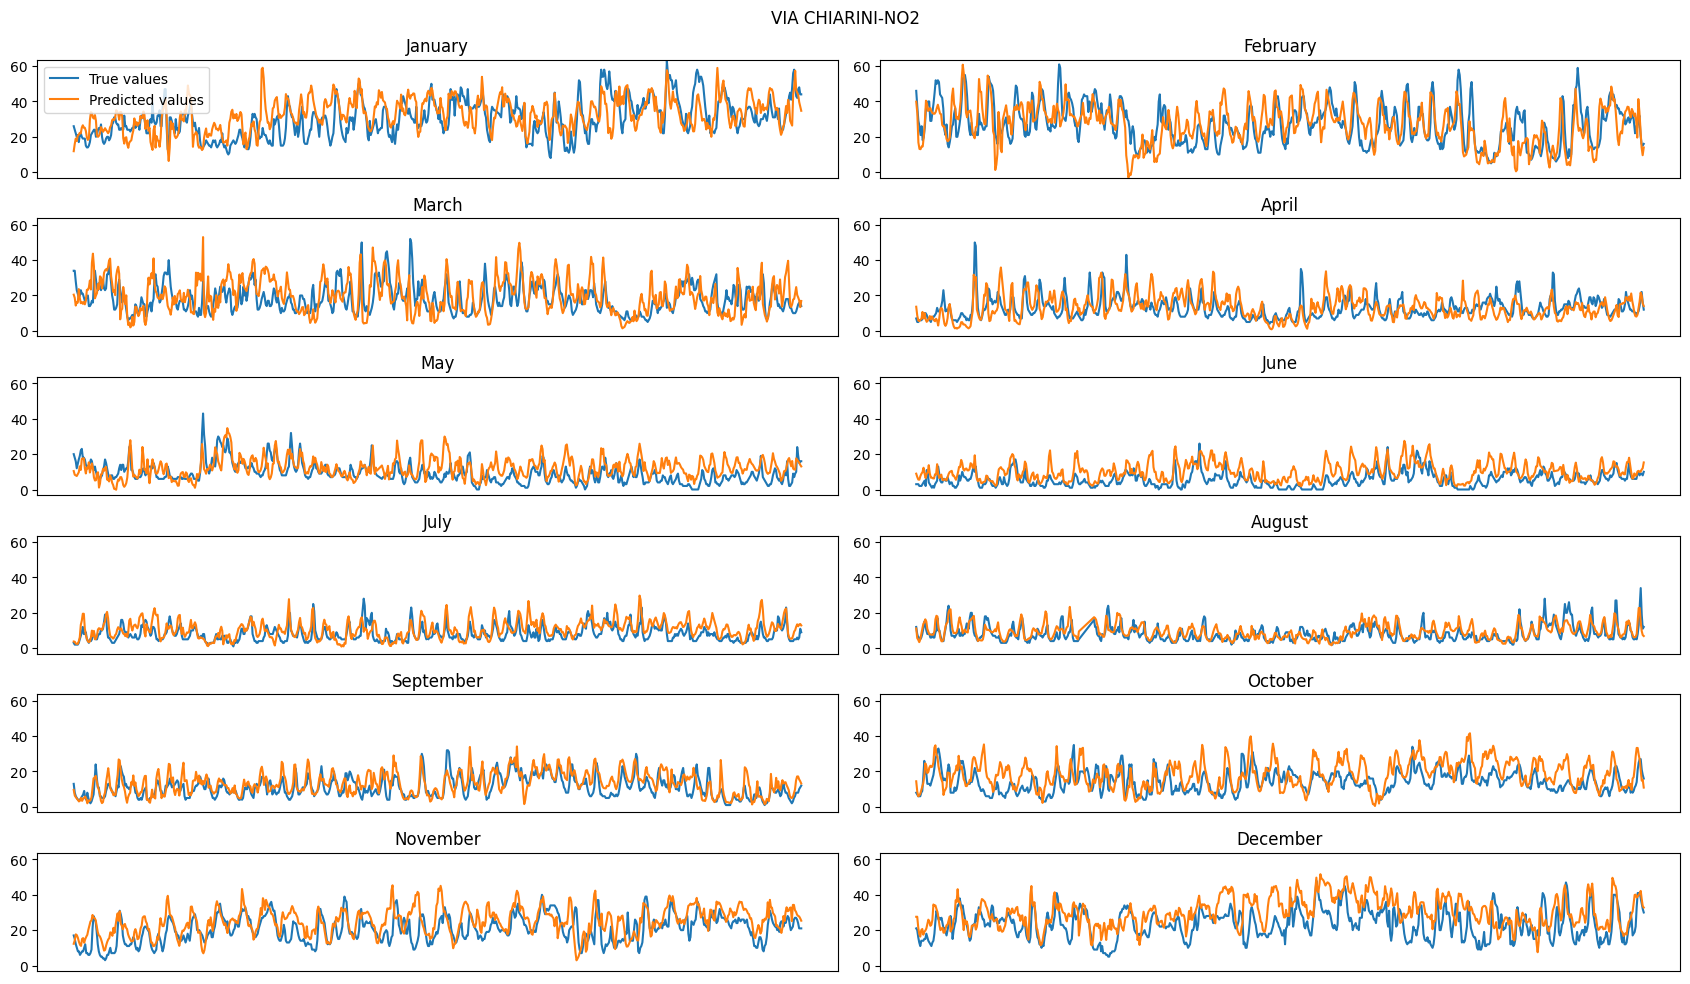

root_mean_squared_error: 0.5866436782902911
r2_score: 0.44205113163479304
mean_absolute_error: 0.4454849212221523
huber: 0.07120788842439651


In [34]:
plot_months_predictions(lstm_y_test, lstm_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}', figsize=(17,10))

#### Feed Forward Neural Network

##### *Models*

In [35]:
ffnn_params = {
    'input_size': n_hour_features,
    'neurons': [1024, 512, 256, 128],
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN'] = (build_ffnn_model, ffnn_params, ffnn_train_params, False)

In [36]:
bn_ffnn_params = {
    'input_size': n_hour_features,
    'neurons': [1024, 512, 256, 128],
    'batch_norm': True,
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

bn_ffnn_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN BatchNorm'] = (build_ffnn_model, bn_ffnn_params, bn_ffnn_train_params, False)

In [37]:
ffnn2_params = {
    'input_size': n_hour_features,
    'neurons': [512, 256, 128],
    'dropout': 0.3,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn2_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN 2'] = (build_ffnn_model, ffnn2_params, ffnn2_train_params, False)

In [38]:
bn_ffnn2_params = {
    'input_size': n_hour_features,
    'neurons': [512, 256, 128],
    'batch_norm': True,
    'dropout': 0.3,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

bn_ffnn2_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN 2 BatchNorm'] = (build_ffnn_model, bn_ffnn2_params, bn_ffnn2_train_params, False)

##### *Testing*

In [39]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_ffnn = 'Feed Forward NN 2 BatchNorm'

In [40]:
tf.keras.backend.clear_session()  
set_random_seed(42) 
ffnn_model = build_ffnn_model(**hour_models[selected_ffnn][1])
ffnn_model.fit(
    merged_train_sets[agent]['x'], 
    merged_train_sets[agent]['y'], 
    **hour_models[selected_ffnn][2]
    )
ffnn_pred = ffnn_model.predict(test_sets[station][agent]['x'])
ffnn_pred_df = pd.DataFrame(ffnn_pred, index=test_sets[station][agent]['y'].index)

Epoch 1/10


/home/davide/Desktop/AI/AIII/project/AII-project/aiii-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4020/4020 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.5988
Epoch 2/10
4020/4020 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.5414
Epoch 3/10
4020/4020 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.5364
Epoch 4/10
4020/4020 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.5324
Epoch 5/10
4020/4020 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.5287
Epoch 6/10
4020/4020 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.5256
Epoch 7/10
4020/4020 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.5234
Epoch 8/10
4020/4020 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.5217
Epoch 9/10
4020/4020 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.5197
Epoch 10/10
4020/4020 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.5194
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


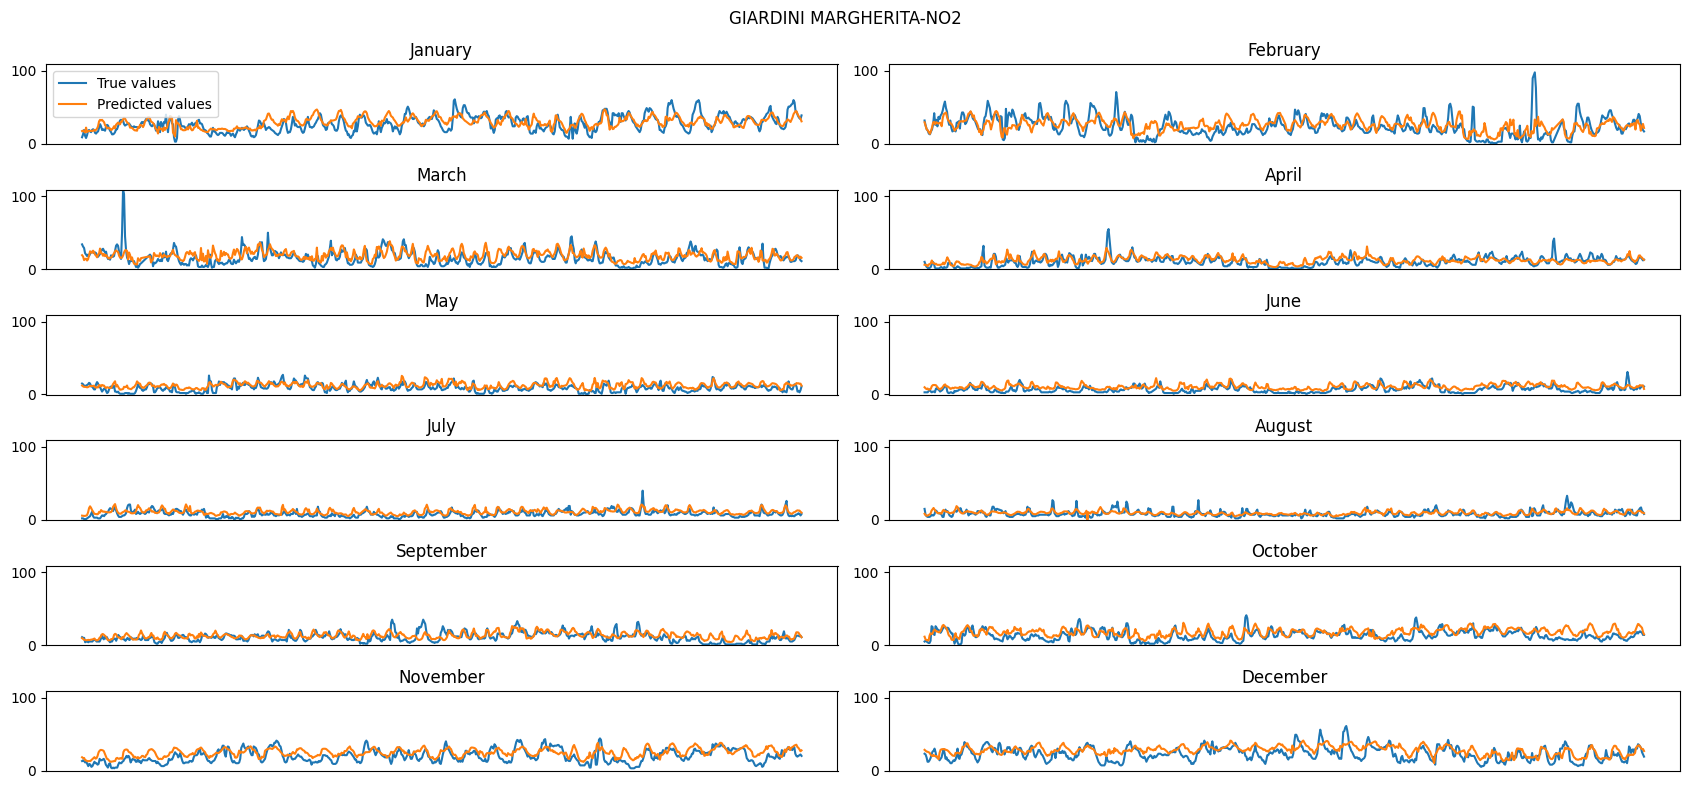

root_mean_squared_error: 0.594279042987915
r2_score: 0.4989789500850338
mean_absolute_error: 0.45072118795720245
huber: 0.0718974769115448


In [41]:
plot_months_predictions(test_sets[station][agent]['y'], ffnn_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

#### Conv1d

##### *Models*

In [42]:
conv_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': 64,
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv_train_params = {
    'epochs': 10,
    'batch_size': 64,
}

hour_models['Conv1D'] = (build_conv_model, conv_params, conv_train_params, True)

In [43]:
conv2_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv2_train_params = {
    'epochs': 10,
    'batch_size': 64,
}

hour_models['Conv1D 2'] = (build_conv_model, conv2_params, conv2_train_params, True)

In [44]:
conv3_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv3_train_params = {
    'epochs': 20,
    'batch_size': 32,
}

hour_models['Conv1D 3'] = (build_conv_model, conv3_params, conv3_train_params, True)

##### *Testing*

In [45]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_conv = 'Conv1D'

In [46]:
validation_ratio = 0.1
selected_conv_model = hour_models[selected_conv]

ts = selected_conv_model[1]['time_steps']
# lstm_X_train, lstm_y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)

conv_X_train, conv_y_train = None, None
for station in stations:
    if agent in train_sets[station].keys():
        X_train, y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)
        if conv_X_train is None:
            conv_X_train = X_train
            conv_y_train = y_train
        else:
            conv_X_train = np.concatenate((conv_X_train, X_train), axis=0)
            conv_y_train = np.concatenate((conv_y_train, y_train), axis=0)

conv_X_test = pd.concat([train_sets[station][agent]['x'].iloc[-ts+1:], test_sets[station][agent]['x']]) # to also compute the first days we need time_steps more days
conv_X_test, conv_y_test = create_sequences(conv_X_test, test_sets[station][agent]['y'], ts, use_mask=False)

conv_X_train, conv_X_val, conv_y_train, conv_y_val = train_test_split(conv_X_train, conv_y_train, test_size=validation_ratio, random_state=42, shuffle=True)

In [47]:
tf.keras.backend.clear_session()  
set_random_seed(42) 
conv_model = build_conv_model(**hour_models[selected_conv][1])
conv_model.fit(
    conv_X_train, 
    conv_y_train, 
    **hour_models[selected_conv][2])
conv_pred = conv_model.predict(conv_X_test)
conv_pred_df = pd.DataFrame(conv_pred, index=conv_y_test.index)

Epoch 1/10


/home/davide/Desktop/AI/AIII/project/AII-project/aiii-venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1809/1809 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.5137
Epoch 2/10
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4792
Epoch 3/10
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4694
Epoch 4/10
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4620
Epoch 5/10
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4570
Epoch 6/10
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.4523
Epoch 7/10
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.4494
Epoch 8/10
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.4457
Epoch 9/10
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4428
Epoch 10/10
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4398
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step


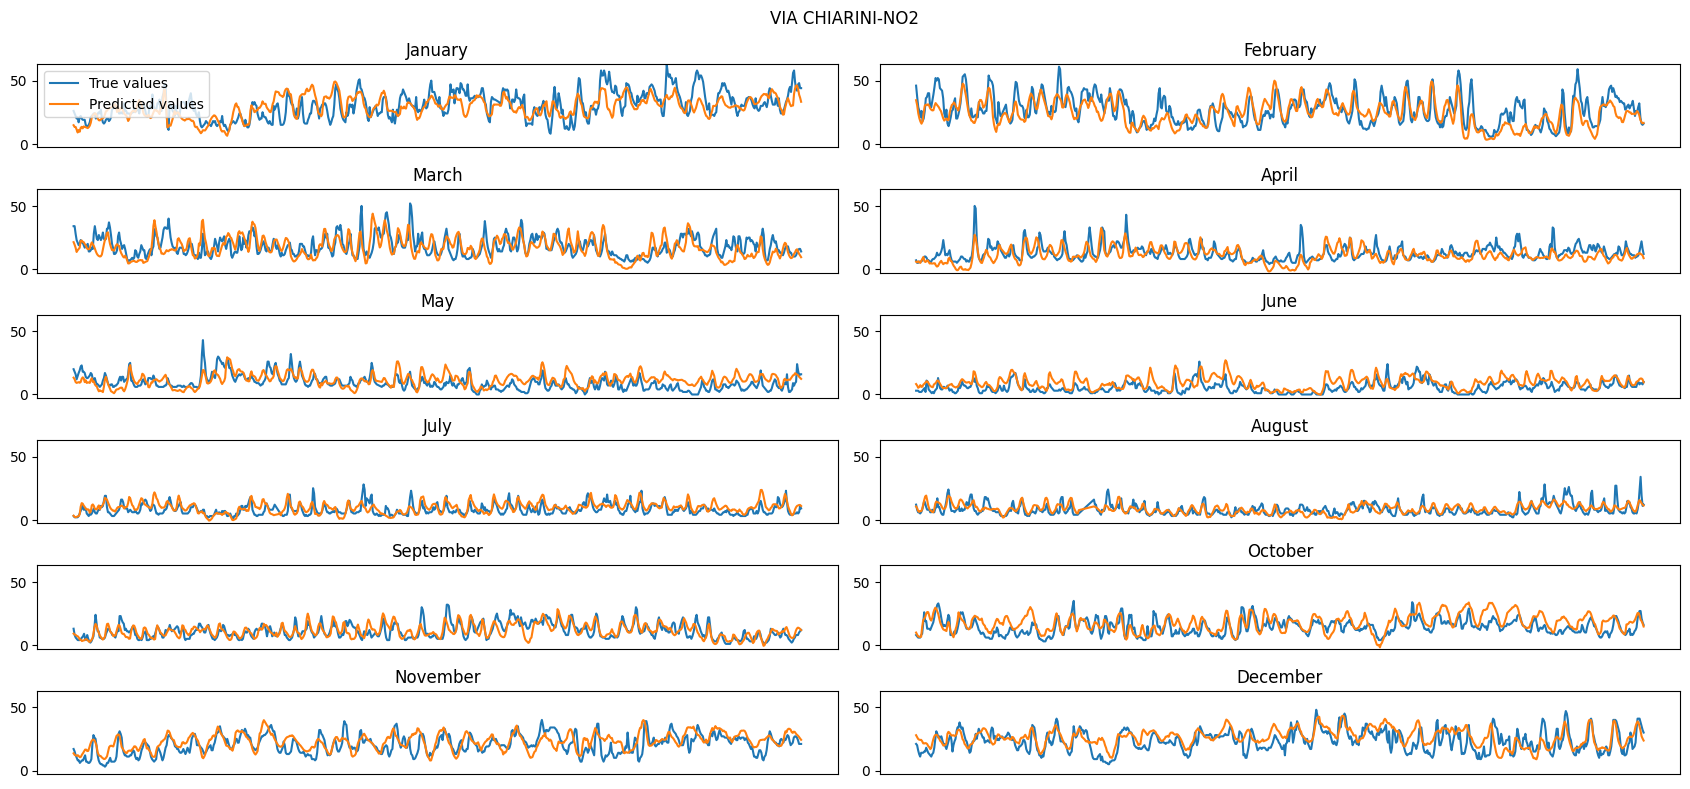

root_mean_squared_error: 0.49837262213992944
r2_score: 0.5973256520708015
mean_absolute_error: 0.3795114626540958
huber: 0.05827338621020317


In [48]:
plot_months_predictions(test_sets[station][agent]['y'], conv_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

### **Daily Models**

In [149]:
daily_models = {} # contains tuples: (ModelClass, model_params:dict, training_params:dict, uses_sequences:bool|dict)

#### Random Forest Regressor

##### *Models*

In [150]:
rfr_params = {
    'n_estimators':100,
    'max_depth':10,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

daily_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

In [151]:
rfr2_params = {
    'n_estimators':150,
    'max_depth':20,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

daily_models['Random Forest Regressor 2'] = (RandomForestRegressor, rfr2_params, None, False)

##### *Testing*

In [52]:
station = 'GIARDINI MARGHERITA'
agent = 'PM10'

selected_daily_rfr = 'Random Forest Regressor'

In [53]:
rfr_daily_model = RandomForestRegressor(**daily_models[selected_daily_rfr][1])
rfr_daily_model.fit(merged_train_sets[agent]['x'], merged_train_sets[agent]['y'].to_numpy().ravel())
rfr_daily_pred = rfr_daily_model.predict(test_sets[station][agent]['x'])
rfr_daily_pred_df = pd.DataFrame(rfr_daily_pred, index=test_sets[station][agent]['y'].index)

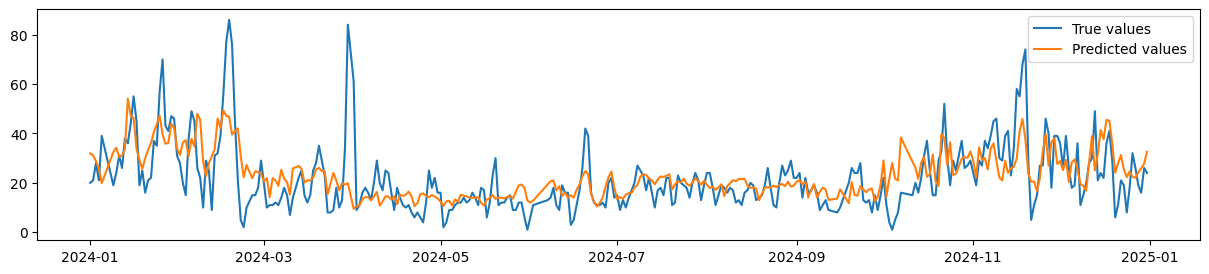

root_mean_squared_error: 0.7366513562360828
r2_score: 0.39880846950345916
mean_absolute_error: 0.5231156875126406
huber: 0.08646176755428314


In [54]:
plot_year_predictions(test_sets[station][agent]['y'], rfr_daily_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### XGBoost Regressor

##### *Models*

In [152]:
xgbr_params = {
    'objective': "reg:squarederror",
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.07,
    'subsample': 0.9,
    'random_state': RANDOM_STATE,
}

daily_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

In [153]:
xgbr_params = {
    'objective': "reg:squarederror",
    'n_estimators': 150,
    'max_depth': 10,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'random_state': RANDOM_STATE,
}

daily_models['XGB Regressor 2'] = (xgb.XGBRegressor, xgbr_params, None, False)

##### *Testing*

In [57]:
station = 'GIARDINI MARGHERITA'
agent = 'PM10'

selected_daily_xgbr = 'XGB Regressor'

In [58]:
validation_ratio = 0.1

X_train, y_train = merged_train_sets[agent]['x'], merged_train_sets[agent]['y']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42, shuffle=True)
validation_data = [(X_val, y_val)]

xgbr_daily_model = xgb.XGBRegressor(**hour_models[selected_daily_xgbr][1])
xgbr_daily_model.fit(X_train, y_train, eval_set=validation_data)
xgbr_daily_pred = xgbr_daily_model.predict(test_sets[station][agent]['x'])
xgbr_daily_pred_df = pd.DataFrame(xgbr_daily_pred, index=test_sets[station][agent]['y'].index)

[0]	validation_0-mae:0.75187
[1]	validation_0-mae:0.73052
[2]	validation_0-mae:0.71083
[3]	validation_0-mae:0.69336
[4]	validation_0-mae:0.67836
[5]	validation_0-mae:0.66253
[6]	validation_0-mae:0.64713
[7]	validation_0-mae:0.63332
[8]	validation_0-mae:0.61982
[9]	validation_0-mae:0.60756
[10]	validation_0-mae:0.59755
[11]	validation_0-mae:0.58803
[12]	validation_0-mae:0.57879
[13]	validation_0-mae:0.57101
[14]	validation_0-mae:0.56190
[15]	validation_0-mae:0.55452
[16]	validation_0-mae:0.54502
[17]	validation_0-mae:0.53915
[18]	validation_0-mae:0.53361
[19]	validation_0-mae:0.52671
[20]	validation_0-mae:0.52159
[21]	validation_0-mae:0.51782
[22]	validation_0-mae:0.51225
[23]	validation_0-mae:0.50579
[24]	validation_0-mae:0.49985
[25]	validation_0-mae:0.49677
[26]	validation_0-mae:0.49417
[27]	validation_0-mae:0.49242
[28]	validation_0-mae:0.48909
[29]	validation_0-mae:0.48555
[30]	validation_0-mae:0.48312
[31]	validation_0-mae:0.47873
[32]	validation_0-mae:0.47655
[33]	validation_0-ma

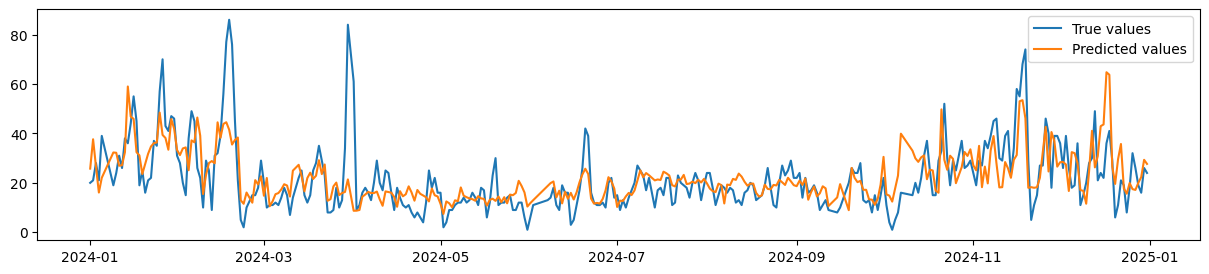

root_mean_squared_error: 0.7254542405201075
r2_score: 0.41694581701327116
mean_absolute_error: 0.5043965733302436
huber: 0.0830104798078537


In [59]:
plot_year_predictions(test_sets[station][agent]['y'], xgbr_daily_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### Feed Forward Neural Network

##### *Models*

In [60]:
ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32,
}

daily_models['Feed Forward NN'] = (build_ffnn_model, ffnn_daily_params, ffnn_daily_train_params, False)

In [61]:
bn_ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'batch_norm': True,
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

bn_ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32,
}

daily_models['Feed Forward NN BatchNorm'] = (build_ffnn_model, bn_ffnn_daily_params, bn_ffnn_daily_train_params, False)

##### *Testing*

In [62]:
station = 'GIARDINI MARGHERITA'
agent = 'PM10'

selected_daily_ffnn = 'Feed Forward NN'

In [63]:
tf.keras.backend.clear_session()  
set_random_seed(42) 
ffnn_daily_model = build_ffnn_model(**daily_models[selected_daily_ffnn][1])
ffnn_daily_model.fit(
    merged_train_sets[agent]['x'], 
    merged_train_sets[agent]['y'], 
    **daily_models[selected_daily_ffnn][2]
    )
ffnn_daily_pred = ffnn_daily_model.predict(test_sets[station][agent]['x'])
ffnn_daily_pred_df = pd.DataFrame(ffnn_daily_pred, index=test_sets[station][agent]['y'].index)

Epoch 1/20


/home/davide/Desktop/AI/AIII/project/AII-project/aiii-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.6191
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5247
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.5052
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4848
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4648
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4525
Epoch 7/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4392
Epoch 8/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4372
Epoch 9/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4222
Epoch 10/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4112
Epoch 11/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4057
Epoch 12/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3970
Epoch 13/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3946
Epoch 14/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3834
Epoch 15/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step -

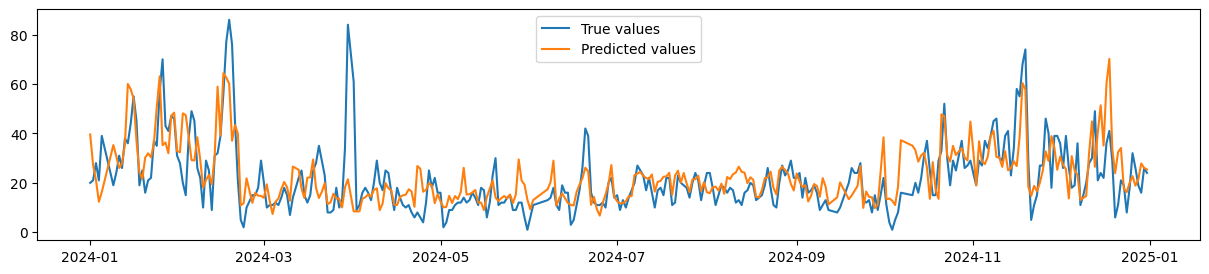

root_mean_squared_error: 0.7362331278876052
r2_score: 0.3994909197929064
mean_absolute_error: 0.5109385092377025
huber: 0.08425556123256683


In [64]:
plot_year_predictions(test_sets[station][agent]['y'], ffnn_daily_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### LSTM

In order to use LSTMs, we need to have sequences/time steps. For the other models, we aggregated the hourly data into a single day, but we could try to go back to hourly inputs aggregated in sequences of 24 hours.

The tests results were not convincing enough to keep experimentating.

## **Agents Evaluations**

### Hourly Models

In [154]:
hour_results = train_models_1_per_agent(
    hour_models, train_sets, merged_train_sets,test_sets,metrics,
    to_execute={
        'agents':'all',
        'stations':'all',
        'models':'all',
    },
    ignore={
        'stations':[],
        'agents':['PM10','PM2.5'],
        'models':[]
        },
    random_state=RANDOM_STATE,
    v=1
)

Train settings:
stations: ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI']
agents: ['NO2', 'O3', 'C6H6', 'CO']
models: ['Random Forest Regressor', 'Random Forest Regressor 2', 'XGB Regressor', 'XGB Regressor 2']
Agent NO2
> Random Forest Regressor model:
> Random Forest Regressor 2 model:
> XGB Regressor model:
> XGB Regressor 2 model:
Agent O3
> Random Forest Regressor model:
> Random Forest Regressor 2 model:
> XGB Regressor model:
> XGB Regressor 2 model:
Agent C6H6
> Random Forest Regressor model:
> Random Forest Regressor 2 model:
> XGB Regressor model:
> XGB Regressor 2 model:
Agent CO
> Random Forest Regressor model:
> Random Forest Regressor 2 model:
> XGB Regressor model:
> XGB Regressor 2 model:


We can extract the results from the training phase, and sort the models using their metrics.

In [157]:
hour_extracted_data = training_results_to_dataframe(hour_results)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(hour_extracted_data.sort_values(by=['Station','Agent','root_mean_squared_error']))

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber,mean_squared_error
2,GIARDINI MARGHERITA,NO2,XGB Regressor,0.582046,0.519394,0.419106,0.066418,0.338777
1,GIARDINI MARGHERITA,NO2,Random Forest Regressor 2,0.593108,0.500952,0.440931,0.070280,0.351777
0,GIARDINI MARGHERITA,NO2,Random Forest Regressor,0.594280,0.498978,0.440734,0.070257,0.353169
3,GIARDINI MARGHERITA,NO2,XGB Regressor 2,0.623852,0.447873,0.454869,0.073230,0.389192
4,GIARDINI MARGHERITA,O3,Random Forest Regressor,0.372753,0.843940,0.285112,0.040238,0.138945
5,GIARDINI MARGHERITA,O3,Random Forest Regressor 2,0.373778,0.843082,0.286527,0.040447,0.139710
6,GIARDINI MARGHERITA,O3,XGB Regressor,0.375111,0.841960,0.280218,0.039829,0.140708
7,GIARDINI MARGHERITA,O3,XGB Regressor 2,0.385957,0.832688,0.288912,0.041304,0.148963
12,PORTA SAN FELICE,C6H6,Random Forest Regressor,0.595244,0.615362,0.377323,0.058561,0.354316
13,PORTA SAN FELICE,C6H6,Random Forest Regressor 2,0.595547,0.614970,0.377404,0.058582,0.354676


And we can display the best model for each station-agent

In [158]:
display(hour_extracted_data.loc[hour_extracted_data.groupby(by=['Station','Agent'])['root_mean_squared_error'].idxmin()])

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber,mean_squared_error
2,GIARDINI MARGHERITA,NO2,XGB Regressor,0.582046,0.519394,0.419106,0.066418,0.338777
4,GIARDINI MARGHERITA,O3,Random Forest Regressor,0.372753,0.843940,0.285112,0.040238,0.138945
12,PORTA SAN FELICE,C6H6,Random Forest Regressor,0.595244,0.615362,0.377323,0.058561,0.354316
18,PORTA SAN FELICE,CO,XGB Regressor,0.666039,0.575752,0.511999,0.084164,0.443608
10,PORTA SAN FELICE,NO2,XGB Regressor,0.965672,-0.726103,0.814173,0.143710,0.932523
22,VIA CHIARINI,NO2,XGB Regressor,0.510368,0.577709,0.392077,0.060622,0.260475
26,VIA CHIARINI,O3,XGB Regressor,0.375849,0.837303,0.282288,0.040427,0.141263


Apparently, there isn't a particular model that performs well on an agent across all the stations. That being said, the loss values are really similar and with a better fine tuning a certain model might become the best for certain agents.

Even if this results descourage it, trying to define per-agent models, instead of the current station-agent models, might be worth it. In that case, the train set would also become larger because the data from all the stations would be used.

##### **EXAMPLE:** how to eventually try new metrics

In [159]:
from sklearn.metrics import mean_squared_error

metrics.append(mean_squared_error) # even if you append multiple times, the result is written on a dict so there are no duplicates

In [160]:
new_hour_results = update_metrics(hour_results, test_sets, metrics)
new_hour_extracted_data = training_results_to_dataframe(new_hour_results)
new_hour_extracted_data.sort_values(by=['Agent','Model','Station'])

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber,mean_squared_error
12,PORTA SAN FELICE,C6H6,Random Forest Regressor,0.595244,0.615362,0.377323,0.058561,0.354316
13,PORTA SAN FELICE,C6H6,Random Forest Regressor 2,0.595547,0.614970,0.377404,0.058582,0.354676
14,PORTA SAN FELICE,C6H6,XGB Regressor,0.595727,0.614737,0.364883,0.056286,0.354891
15,PORTA SAN FELICE,C6H6,XGB Regressor 2,0.632654,0.565495,0.401890,0.063409,0.400251
16,PORTA SAN FELICE,CO,Random Forest Regressor,0.681288,0.556103,0.543110,0.090060,0.464154
17,PORTA SAN FELICE,CO,Random Forest Regressor 2,0.677886,0.560526,0.541100,0.089611,0.459529
18,PORTA SAN FELICE,CO,XGB Regressor,0.666039,0.575752,0.511999,0.084164,0.443608
19,PORTA SAN FELICE,CO,XGB Regressor 2,0.742375,0.472932,0.585265,0.098527,0.551120
0,GIARDINI MARGHERITA,NO2,Random Forest Regressor,0.594280,0.498978,0.440734,0.070257,0.353169
8,PORTA SAN FELICE,NO2,Random Forest Regressor,1.007620,-0.879319,0.861808,0.153125,1.015298


### Daily Models

In [161]:
daily_results = train_models_1_per_agent(
    daily_models, train_sets, merged_train_sets, test_sets, metrics,
    to_execute={
        'agents':['PM10','PM2.5'],
        'stations':'all',
        'models':'all',
        },
    ignore={
        'stations':[],
        'agents':[],
        'models':[]
        },
    v=1
)

Train settings:
stations: ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI']
agents: ['PM10', 'PM2.5']
models: ['Random Forest Regressor', 'Random Forest Regressor 2', 'XGB Regressor', 'XGB Regressor 2']
Agent PM10
> Random Forest Regressor model
> Random Forest Regressor 2 model
> XGB Regressor model
> XGB Regressor 2 model
Agent PM2.5
> Random Forest Regressor model
> Random Forest Regressor 2 model
> XGB Regressor model
> XGB Regressor 2 model


In [162]:
daily_extracted_data = training_results_to_dataframe(daily_results)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(daily_extracted_data.sort_values(by=['Station','Agent','root_mean_squared_error']))

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber,mean_squared_error
0,GIARDINI MARGHERITA,PM10,Random Forest Regressor,0.736651,0.398808,0.523116,0.086462,0.542655
1,GIARDINI MARGHERITA,PM10,Random Forest Regressor 2,0.738228,0.396232,0.525213,0.086935,0.544981
2,GIARDINI MARGHERITA,PM10,XGB Regressor,0.741349,0.391116,0.524098,0.086945,0.549599
3,GIARDINI MARGHERITA,PM10,XGB Regressor 2,0.759303,0.361267,0.543371,0.090330,0.576541
5,GIARDINI MARGHERITA,PM2.5,Random Forest Regressor 2,0.740925,0.466957,0.511359,0.084339,0.548970
4,GIARDINI MARGHERITA,PM2.5,Random Forest Regressor,0.741680,0.465872,0.511283,0.084207,0.550089
6,GIARDINI MARGHERITA,PM2.5,XGB Regressor,0.781554,0.406895,0.518717,0.086026,0.610827
7,GIARDINI MARGHERITA,PM2.5,XGB Regressor 2,0.804514,0.371536,0.540710,0.090283,0.647243
8,PORTA SAN FELICE,PM10,Random Forest Regressor,0.718740,0.488650,0.492025,0.080302,0.516587
9,PORTA SAN FELICE,PM10,Random Forest Regressor 2,0.719452,0.487637,0.497310,0.080981,0.517611


In [163]:
display(daily_extracted_data.loc[daily_extracted_data.groupby(by=['Station','Agent'])['root_mean_squared_error'].idxmin()])

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber,mean_squared_error
0,GIARDINI MARGHERITA,PM10,Random Forest Regressor,0.736651,0.398808,0.523116,0.086462,0.542655
5,GIARDINI MARGHERITA,PM2.5,Random Forest Regressor 2,0.740925,0.466957,0.511359,0.084339,0.548970
8,PORTA SAN FELICE,PM10,Random Forest Regressor,0.718740,0.488650,0.492025,0.080302,0.516587
12,PORTA SAN FELICE,PM2.5,Random Forest Regressor,0.670582,0.563504,0.476560,0.077199,0.449680
16,VIA CHIARINI,PM10,Random Forest Regressor,0.833795,0.325837,0.619989,0.105455,0.695214
